In [1]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from random import randint

# load the time function to measure time
from time import time

# Measuring time

In [2]:
# The function time.time() gives the number of seconds since
# 1.1.1970 (also known as "unix time"). The difference
# between repeated calls can be used to measure time.

print('The current unix time is: ', time())

tic = time()
print('Hello!')
toc = time()
print(f'Printing "Hello!" just now took {toc - tic} seconds')

The current unix time is:  1612106606.387305
Hello!
Printing "Hello!" just now took 0.0001671314239501953 seconds


In [3]:
# Another way of measuring time is to use the %timeit ipython magic
# See also https://ipython.readthedocs.io/en/stable/interactive/magics.html

def random_mean(N):
    return np.mean(np.random.random(N))

%timeit mean = random_mean(10000)

63.9 µs ± 574 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Tip no. 1: Avoid for-loops when possible

In [4]:
def sum_of_integers_pure_python(N):
    total = 0
    for i in range(N):
        total += i
    return total

def sum_of_integers_numpy(N):
    return np.sum(np.arange(N))

def sum_of_integers_built_in(N):
    return sum(np.arange(N))

In [5]:
# Simple timing with time()

N = 10000000

tic = time()
total = sum_of_integers_pure_python(N)
toc = time()

print(f'Calculation took {toc - tic:.5f} seconds in pure python')

tic = time()
total = sum_of_integers_numpy(N)
toc = time()

print(f'Calculation took {toc - tic:.5f} seconds with numpy')

tic = time()
total = sum_of_integers_built_in(N)
toc = time()

print(f'Calculation took {toc - tic:.5f} seconds with built-in sum')

Calculation took 0.50829 seconds in pure python
Calculation took 0.05113 seconds with numpy
Calculation took 1.29727 seconds with built-in sum


In [6]:
# More fancy timing with %timeit
# (takes a bit longer because it runs several times to get statistics)

N = 10000000

print('Pure python: ', end = '')
%timeit sum_of_integers_pure_python(N)

print('Numpy:       ', end = '')
%timeit sum_of_integers_numpy(N)

Pure python: 495 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Numpy:       17.4 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Tip no. 2: Operate on whole arrays where possible

Most numpy functions, including functions that operate on vectors and matrices, can operate on whole arrays of vectors and matrices.

In [7]:
# Take sin() of all elements in array

N = 1000000
x = np.linspace(0, 1, N)
y = np.zeros(N)

tic = time()
for i in range(N):
    y[i] = np.sin(x[i])
toc = time()
print(f'Calculation took {toc - tic:.5f} seconds with loop over elements')

tic = time()
y = np.sin(x)
toc = time()
print(f'Calculation took {toc - tic:.5f} seconds with numpy')

Calculation took 1.28815 seconds with loop over elements
Calculation took 0.00924 seconds with numpy


In [8]:
# Less obvious example: Find eigenvalues and eigenvectors of 200000 2x2 matrices
N = 200000
matrices = np.random.random(size = (N, 2, 2))
eigvals = np.zeros((N, 2))
eigvecs = np.zeros((N, 2, 2))

tic = time()
for i in range(N):
    eigvals[i,:], eigvecs[i,:] = np.linalg.eig(matrices[i,:])
toc = time()
print(f'Calculation took {toc - tic:.5f} seconds with loop over 2x2 matrices')

tic = time()
eigvals, eigvecs = np.linalg.eig(matrices)
toc = time()
print(f'Calculation took {toc - tic:.5f} seconds with numpy')

Calculation took 4.89490 seconds with loop over 2x2 matrices
Calculation took 0.40331 seconds with numpy


# Tip no. 3: Use profiling to _measure_ where the time is spent

In [9]:
# Load an extension for profiling
# If this fails, try installing line_profiler with pip or conda
%load_ext line_profiler

In [10]:
def do_something(x):
    # Multiply all elements by 2
    for i in range(len(x)):
        x[i] = 2*x[i]
    return x

def do_something_else(x):
    # Shuffle array by swapping random elements
    # (this is just an example, not a good shuffling algorithm)
    for i in range(len(x)):
        i = randint(0, len(x)-1)
        j = randint(0, len(x)-1)
        x[i], x[j] = x[j], x[i]
    return x

def simulation(x, N):
    for i in range(N):
        x = do_something(x)
        x = do_something_else(x)
    return x

In [11]:
# Try profiling
N = 1000
x = np.random.random(N)

%lprun -f simulation x = simulation(x, N)

In [12]:
def do_something_else_faster(x):
    # Use numpy built-in function to shuffle
    # (this function shuffles in place, so must return separately)
    np.random.shuffle(x)
    return x

def simulation(x, N):
    for i in range(N):
        x = do_something(x)
        x = do_something_else_faster(x)
    return x

In [13]:
# Try profiling again

N = 1000
x = np.random.random(N)

%lprun -f simulation x = simulation(x, N)

In [14]:
def do_something_faster(x):
    # Multiply all elements by 2
    return 2*x

def simulation(x, N):
    for i in range(N):
        x = do_something_faster(x)
        x = do_something_else_faster(x)
    return x

In [15]:
# Try profiling yet again

N = 1000
x = np.random.random(N)

%lprun -f simulation x = simulation(x, N)

# Tip no. 4: Sometimes numba is useful when it's difficult to avoid for loops

Numba is a just-in-time (JIT) compiler for python.

https://numba.pydata.org/

## Example: The Mandelbrot set

The Mandelbrot set is the set of points, $c$, in the complex plane such that $z_i$ remains bounded under repeated iterations of
$$ z_{i+1} \to z_i^2 + c, \;\;\;\; \mathrm{with} \;\; z_0 = 0 $$

In [16]:
from numba import jit

In [17]:
# One iterator function that can be applied to calculate both
# the Mandelbrot and the Julia set.
# The nopython keyword to @jit ensures that numba gives
# an error if it cannot produce fast compiled code.

# Comment out the line below, and see the difference
@jit(nopython = True)
def iterator(z, c, maxiter):
    for i in range(maxiter):
        z = z*z + c
        if abs(z) > 2:
            return i
    return maxiter

# Comment out the line below, and see the difference
@jit(nopython = True)
def mandelbrot(Nx, Ny, xmin=-2, xmax=1, ymin=-1, ymax=1, maxiter=50):
    x = np.linspace(xmin, xmax, Nx)
    y = np.linspace(ymin, ymax, Ny)
    m = np.empty((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            m[i,j] = iterator(z = 0, c = x[i] + 1j*y[j], maxiter = maxiter)
    return x, y, m

Calculating the set took 0.62154 seconds


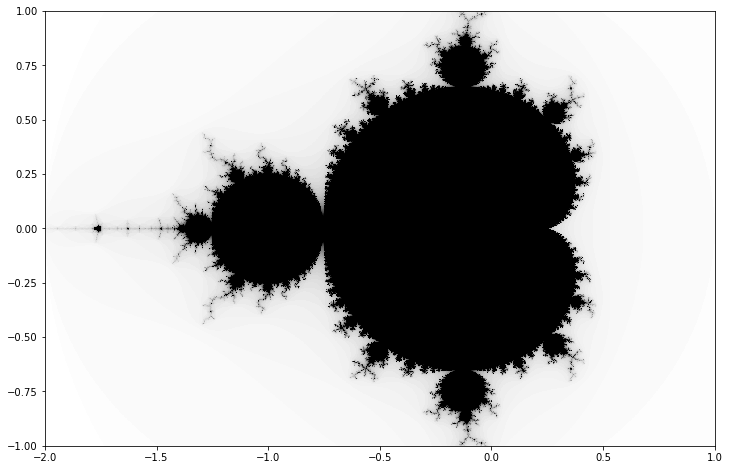

In [18]:
Nx = 1500
Ny = 1000

tic = time()
x, y, m = mandelbrot(Nx, Ny)
toc = time()
print(f'Calculating the set took {toc - tic:.5f} seconds')

fig = plt.figure(figsize = (12, 8))
plt.pcolormesh(x, y, m[:-1,:-1].T, cmap = 'Greys')

## Another example: Interactive plotting of the Julia Set

In [19]:
from ipywidgets import interact

In [20]:
@jit(nopython = True)
def julia(c, Nx, Ny, xmin=-1.5, xmax=1.5, ymin=-1., ymax=1., maxiter=100):
    x = np.linspace(xmin, xmax, Nx)
    y = np.linspace(ymin, ymax, Ny)
    m = np.empty((Nx, Ny))
    for i in range(Nx):
        for j in range(Ny):
            m[i,j] = iterator(z = x[i] + 1j*y[j], c = c, maxiter = maxiter)
    return x, y, m

In [21]:
def plotter(c):
    Nx = 300
    Ny = 200
    c = 0.02 + 1j*c
    x, y, m = julia(c, Nx, Ny)
    fig = plt.figure(1, figsize = (10,6))
    plt.pcolormesh(x, y, m[:-1,:-1].T, cmap = 'viridis')

slider = interact(plotter, c = (0.0, 1.5, 0.02))

interactive(children=(FloatSlider(value=0.74, description='c', max=1.5, step=0.02), Output()), _dom_classes=('…

# Tip no. 5: Don't store numbers as text
## (unless it's just a few numbers, and editing a text file is convenient)

* Storing a 16-digit number (with sign and exponent, and a separator) as text takes about 24 bytes.
* Storing a double precision number (approx. 16 digits + exponential and sign) in binary format takes exactly 8 bytes.
* Storing as binary is faster, because the contents of memory can be written directly to disk, without conversion
* Numpy has built-in support for storing arrays in binary format:
 * https://numpy.org/doc/stable/reference/generated/numpy.save.html
 * https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html#module-numpy.lib.format

If you need to exchange data with another programming language, look at portable standard formats such as HDF5 and netCDF.
* https://docs.h5py.org/en/stable/
* https://unidata.github.io/netcdf4-python/
* http://xarray.pydata.org/en/stable/io.html

In [22]:
# Printing -pi with 16 digits, sign and exponent as example
print(f'{-np.pi:.16e}')

-3.1415926535897931e+00


In [23]:
# Generate an array with 100000 random numbers
a = np.random.random(100000)

# Store to disk as txt
tic = time()
np.savetxt('a.txt', a)
toc = time()
print(f'Saving as text took    {(toc - tic):.5f} seconds')

# Save to disk as binary
tic = time()
np.save('a.npy', a)
toc = time()
print(f'Saving as binary took  {(toc - tic):.5f} seconds')

Saving as text took    0.17386 seconds
Saving as binary took  0.00616 seconds


# Semi-realistic example: 1D advection-diffusion equation with periodic boundary conditions

The one-dimensional advection-diffusion equation for constant diffusivity, $D$, and advection velocity, $v$ is:

$$ \frac{\partial C(x,t)}{\partial t} = D\frac{\partial^2 C(x,t)}{\partial x^2} - v\frac{\partial C(x,t)}{\partial z}. $$

Just as an example we will solve this with central finite differences in space, and forward Euler in time (do not worry if you're not familiar with these terms, both will be covered later in the course). See for example https://en.wikipedia.org/wiki/Finite_difference

We introduce discrete variables:

$$ x_i = x_0 + i \Delta x, \;\;\;\; t_n = t_0 + n \Delta t.$$

Then we discretise the spatial derivatives:

$$ \left.\frac{\partial^2 C(x, t)}{\partial x^2}\right|_{x_i} \approx \frac{C(x_{i+1}, t) - 2C(x_i, t) + C(x_{i-1}, t)} {\Delta x^2},$$

$$ \left.\frac{\partial C(x, t)}{\partial x}\right|_{x_i} \approx \frac{C(x_{i+1}, t) - C(x_{i-1}, t)} {2 \Delta x}.$$

Combining these with the forward Euler method, we get

$$ C(x_i, t_{n+1}) \approx C(x_i, t_n) + \Delta t \left[ D \frac{C(x_{i+1}, t_n) - 2C(x_i, t_n) + C(x_{i-1}, t_n)} {\Delta x^2} - v \frac{C(x_{i+1}, t_n) - C(x_{i-1}, t_n)} {2 \Delta x} \right]. $$

In [69]:
# Implementing the update rule for one timestep
# Forward time, central space (FTCS)
def FTCS_loop(C, D, v, dx, dt):
    # Make a new empty array to hold the updated values
    Cnew = np.empty_like(C)
    # Using a for-loop to begin with
    # Handle interior points first
    for i in range(1, len(C)-1):
        Cnew[i] = C[i] + dt*(D*(C[i+1] - 2*C[i] + C[i-1])/dx**2  -  v*(C[i+1] - C[i-1])/(2*dx))
    # Then, handle boundary points to get periodic BC
    Cnew[ 0] = C[ 0] + dt*(D*(C[1] - 2*C[ 0] + C[-1])/dx**2  -  v*(C[1] - C[-1])/(2*dx))
    Cnew[-1] = C[-1] + dt*(D*(C[0] - 2*C[-1] + C[-2])/dx**2  -  v*(C[0] - C[-2])/(2*dx))
    # Return the updated values
    return Cnew

# A function to run a whole simulation
def run_loop(C0, D, v, X, T):
    # Make a copy to avoid overwriting the initial condition
    C = C0.copy()
    # Find dx and dt (assuming constant spacing)
    dx = X[1] - X[0]
    dt = T[1] - T[0]
    # Run simulation for each value in T
    for i in range(len(T)):
        C = FTCS_loop(C, D, v, dx, dt)
    # Return results at
    return C

In [70]:
# Set up and run simulation
D = 0.002 # Diffusivity
v = 0.1 # Advection velocity
T = np.linspace(0, 2, 8001) # time coordinates
X = np.linspace(0, 1, 1001) # x coordinates
# Initial concentration
mu = 0.5
sigma = 0.1
C0 = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(X - mu)**2 / (2*sigma**2))

# Check stability (this number should be smaller than 1/2)
print(f'D dt/dx**2 = {D*(T[1]-T[0])/(X[1]-X[0])**2:.4f}')

tic = time()
C = run_loop(C0, D, v, X, T)
toc = time()
print(f'Running simulation took {toc - tic:.5f} seconds')

D dt/dx**2 = 0.5000
Running simulation took 18.25881 seconds


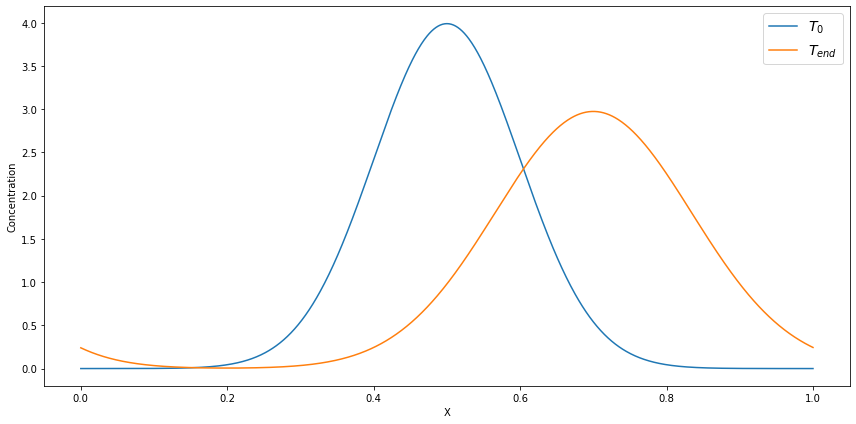

In [71]:
fig = plt.figure(figsize = (12, 6))
plt.plot(X, C0, label = '$T_0$')
plt.plot(X, C, label = '$T_{end}$')
plt.legend(fontsize = 14)
plt.xlabel('X')
plt.ylabel('Concentration')
plt.tight_layout()

In [27]:
# Profiling to find out where time is spent
%lprun -f FTCS_loop run_loop(C0, D, v, X, T)

## Step one: Get rid of the inner for loop

In [72]:
# Implementing the update rule for one timestep
# Forward time, central space (FTCS)
def FTCS_array(C, D, v, dx, dt):
    # Make a new empty array to hold the updated values
    Cnew = np.empty_like(C)
    # Using offset indexing of array to avoid for loop
    # Handle interior points first
    Cnew[1:-1] = C[1:-1] + dt*(D*(C[2:] - 2*C[1:-1] + C[:-2])/dx**2  -  v*(C[2:] - C[:-2])/(2*dx))
    # Then, handle boundary points to get periodic BC
    Cnew[ 0] = C[ 0] + dt*(D*(C[1] - 2*C[ 0] + C[-1])/dx**2  -  v*(C[1] - C[-1])/(2*dx))
    Cnew[-1] = C[-1] + dt*(D*(C[0] - 2*C[-1] + C[-2])/dx**2  -  v*(C[0] - C[-2])/(2*dx))
    # Return the updated values
    return Cnew

# A function to run a whole simulation
def run_array(C0, D, v, X, T):
    # Make a copy to avoid overwriting the initial condition
    C = C0.copy()
    # Find dx and dt (assuming constant spacing)
    dx = X[1] - X[0]
    dt = T[1] - T[0]
    # Run simulation for each value in T
    for i in range(len(T)):
        C = FTCS_array(C, D, v, dx, dt)
    # Return results at
    return C

In [73]:
# Set up and run simulation
D = 0.002 # Diffusivity
v = 0.1 # Advection velocity
T = np.linspace(0, 2, 8001) # time coordinates
X = np.linspace(0, 1, 1001) # x coordinates
# Initial concentration
mu = 0.5
sigma = 0.1
C0 = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(X - mu)**2 / (2*sigma**2))

# Check stability (this number should be smaller than 1/2)
print(f'D dt/dx**2 = {D*(T[1]-T[0])/(X[1]-X[0])**2:.4f}')

tic = time()
C = run_array(C0, D, v, X, T)
toc = time()
print(f'Running simulation took {toc - tic:.5f} seconds')

D dt/dx**2 = 0.5000
Running simulation took 0.19328 seconds


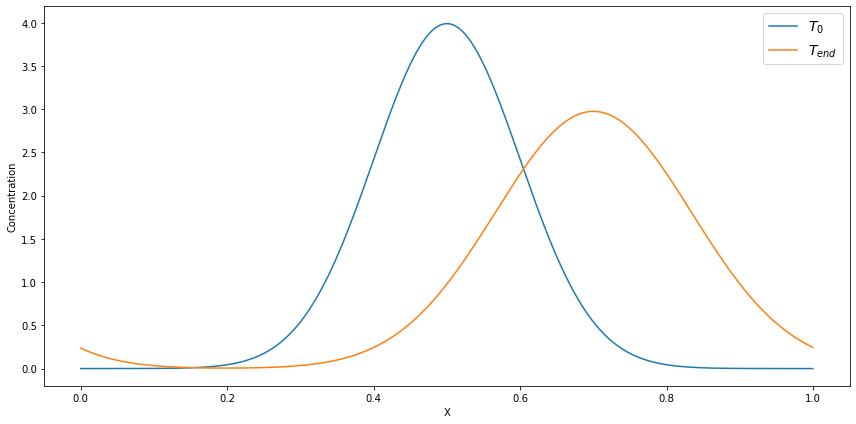

In [30]:
fig = plt.figure(figsize = (12, 6))
plt.plot(X, C0, label = '$T_0$')
plt.plot(X, C, label = '$T_{end}$')
plt.legend(fontsize = 14)
plt.xlabel('X')
plt.ylabel('Concentration')
plt.tight_layout()

In [31]:
# Profiling to find out where time is spent
%lprun -f FTCS_array run_array(C0, D, v, X, T)

## Step 2: Other minor improvements:
* Avoid handling boundary conditions separately
* Avoid copying array every timestep
* Simplify expressions to reduce number of operations

In [32]:
# Implementing the update rule for one timestep
# Forward time, central space (FTCS)
def FTCS_array_ghost(C, D, v, dx, dt):
    # prefactors
    a = dt/(dx**2)
    b = dt/(2*dx)
    C[1:-1] = (1 - 2*D*a)*C[1:-1] + (D*a - v*b)*C[2:] + (D*a + v*b)*C[:-2]
    # Copy boundary points to opposite end
    C[-1] = C[ 1] # First real point copied to last ghost point
    C[ 0] = C[-2] # Last real point copied to first ghost point
    # Return the updated values
    return C

# A function to run a whole simulation
def run_array_ghost(C0, D, v, X, T):
    # Make an array with two extra points (ghost points),
    # to facilitate dealing with boundary conditions
    C = np.empty(C0.size + 2)
    # Make a copy to avoid overwriting the initial condition
    C[1:-1] = C0.copy()
    # Copy boundary points to opposite end
    C[ 0] = C[-2] # First real point copied to last ghost point
    C[-1] = C[-1] # Last real point copied to first ghost point
    # Find dx and dt (assuming constant spacing)
    dx = X[1] - X[0]
    dt = T[1] - T[0]
    # Run simulation for each value in T
    for i in range(len(T)):
        C = FTCS_array_ghost(C, D, v, dx, dt)
    # Return only the real points
    return C[1:-1]

In [74]:
# Set up and run simulation
D = 0.002 # Diffusivity
v = 0.1 # Advection velocity
T = np.linspace(0, 2, 8001) # time coordinates
X = np.linspace(0, 1, 1001) # x coordinates
# Initial concentration
mu = 0.5
sigma = 0.1
C0 = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(X - mu)**2 / (2*sigma**2))

# Check stability (this number should be smaller than 1/2)
print(f'D dt/dx**2 = {D*(T[1]-T[0])/(X[1]-X[0])**2:.4f}')

tic = time()
C = run_array_ghost(C0, D, v, X, T)
toc = time()
print(f'Running simulation took {toc - tic:.5f} seconds')

D dt/dx**2 = 0.5000
Running simulation took 0.09277 seconds


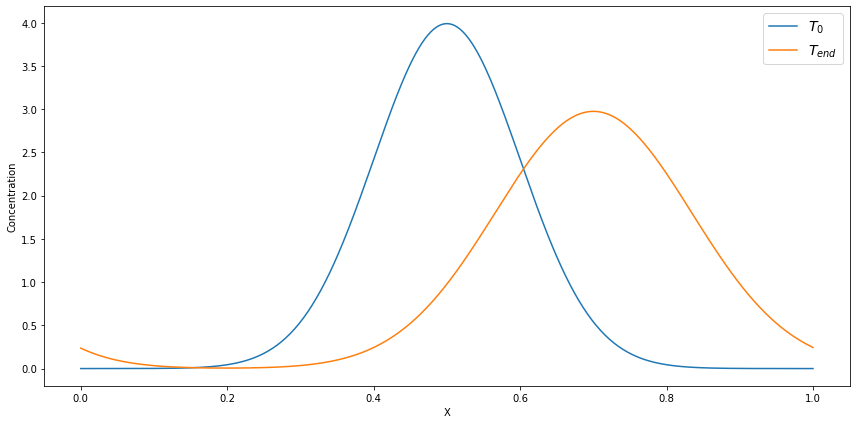

In [34]:
fig = plt.figure(figsize = (12, 6))
plt.plot(X, C0, label = '$T_0$')
plt.plot(X, C, label = '$T_{end}$')
plt.legend(fontsize = 14)
plt.xlabel('X')
plt.ylabel('Concentration')
plt.tight_layout()

In [35]:
# Profiling to find out where time is spent
%lprun -f FTCS_array_ghost run_array_ghost(C0, D, v, X, T)

# Step 3: Compile with numba
## (should maybe have been step 1 or 2)

Some things to remember with numba:
* A function compiled with numba can only call:
 * Numpy functions
 * Other functions that are also compiled with numba
* A function compiled with numba should only take numpy arrays and numbers as input
* A function is compiled the first time you run it (just-in-time compilation, jit)
* For more advanced use, refer to the documentation: https://numba.pydata.org/

If you use numba in a jupyter notebook, be aware that if you re-run the cell where the function is defined, it will be compiled again the next time you run it. So if you keep re-running the cell where the function is defined, you will keep re-compiling the function, which takes time.

In [75]:
# Implementing the update rule for one timestep
# Forward time, central space (FTCS)
@jit(nopython = True)
def FTCS_array_ghost_numba(C, D, v, dx, dt):
    # prefactors
    a = dt/(dx**2)
    b = dt/(2*dx)
    C[1:-1] = (1 - 2*D*a)*C[1:-1] + (D*a - v*b)*C[2:] + (D*a + v*b)*C[:-2]
    # Copy boundary points to opposite end
    C[-1] = C[ 1] # First real point copied to last ghost point
    C[ 0] = C[-2] # Last real point copied to first ghost point
    # Return the updated values
    return C

# A function to run a whole simulation
@jit(nopython = True)
def run_array_ghost_numba(C0, D, v, X, T):
    # Make an array with two extra points (ghost points),
    # to facilitate dealing with boundary conditions
    C = np.empty(C0.size + 2)
    # Make a copy to avoid overwriting the initial condition
    C[1:-1] = C0.copy()
    # Copy boundary points to opposite end
    C[ 0] = C[-2] # First real point copied to last ghost point
    C[-1] = C[-1] # Last real point copied to first ghost point
    # Find dx and dt (assuming constant spacing)
    dx = X[1] - X[0]
    dt = T[1] - T[0]
    # Run simulation for each value in T
    for i in range(len(T)):
        C = FTCS_array_ghost_numba(C, D, v, dx, dt)
    # Return only the real points
    return C[1:-1]

In [77]:
# Set up and run simulation
D = 0.002 # Diffusivity
v = 0.1 # Advection velocity
T = np.linspace(0, 2, 8001) # time coordinates
X = np.linspace(0, 1, 1001) # x coordinates
# Initial concentration
mu = 0.5
sigma = 0.1
C0 = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(X - mu)**2 / (2*sigma**2))

# Check stability (this number should be smaller than 1/2)
print(f'D dt/dx**2 = {D*(T[1]-T[0])/(X[1]-X[0])**2:.4f}')

tic = time()
C = run_array_ghost_numba(C0, D, v, X, T)
toc = time()
print(f'Running simulation took {toc - tic:.5f} seconds')

D dt/dx**2 = 0.5000
Running simulation took 0.01351 seconds


# Step 0: Go back to the original slow functions with a loop over array elements, and compile that with numba

Actually, this turns out to be just as fast as compiling the optimised version above.

In [78]:
# Implementing the update rule for one timestep
# Forward time, central space (FTCS)
@jit(nopython=True)
def FTCS_loop(C, D, v, dx, dt):
    # Make a new empty array to hold the updated values
    Cnew = np.empty_like(C)
    # Using a for-loop to begin with
    # Handle interior points first
    for i in range(1, len(C)-1):
        Cnew[i] = C[i] + dt*(D*(C[i+1] - 2*C[i] + C[i-1])/dx**2  -  v*(C[i+1] - C[i-1])/(2*dx))
    # Then, handle boundary points to get periodic BC
    Cnew[ 0] = C[ 0] + dt*(D*(C[1] - 2*C[ 0] + C[-1])/dx**2  -  v*(C[1] - C[-1])/(2*dx))
    Cnew[-1] = C[-1] + dt*(D*(C[0] - 2*C[-1] + C[-2])/dx**2  -  v*(C[0] - C[-2])/(2*dx))
    # Return the updated values
    return Cnew

# A function to run a whole simulation
@jit(nopython=True)
def run_loop(C0, D, v, X, T):
    # Make a copy to avoid overwriting the initial condition
    C = C0.copy()
    # Find dx and dt (assuming constant spacing)
    dx = X[1] - X[0]
    dt = T[1] - T[0]
    # Run simulation for each value in T
    for i in range(len(T)):
        C = FTCS_loop(C, D, v, dx, dt)
    # Return results at
    return C

In [79]:
# Set up and run simulation
D = 0.002 # Diffusivity
v = 0.1 # Advection velocity
T = np.linspace(0, 2, 8001) # time coordinates
X = np.linspace(0, 1, 1001) # x coordinates
# Initial concentration
mu = 0.5
sigma = 0.1
C0 = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(X - mu)**2 / (2*sigma**2))

# Check stability (this number should be smaller than 1/2)
print(f'D dt/dx**2 = {D*(T[1]-T[0])/(X[1]-X[0])**2:.4f}')

tic = time()
C = run_array_ghost_numba(C0, D, v, X, T)
toc = time()
print(f'Running simulation took {toc - tic:.5f} seconds')

D dt/dx**2 = 0.5000
Running simulation took 0.01412 seconds
